# MovieLens

먼저 데이터를 불러옵니다.

In [77]:
import pandas as pd

def data_loader(file_path):
    file_list = file_path.split(', ')
    ratings = pd.read_table(file_list[0], sep="::", header=None, names=['UserID', 'MovieID', 'Rating', 'timestamp'])
    users = pd.read_table(file_list[1], sep="::", header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])
    movies = pd.read_table(file_list[2], sep="::", header=None, names=['MovieID', 'Title', 'Genres'])
    return ratings, users, movies

file_path = 'ratings.dat, users.dat, movies.dat'
ratings, users, movies = data_loader(file_path)

C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """
C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


In [78]:
ratings.head()

,UserID,MovieID,Rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [79]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [80]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


추천시스템 디자인을 위해 가장 먼저 해야할 작업은 주어진 데이터에 몇 명의 User와 Item이 있는지 확인하는 것입니다. 

ratings 데이터프레임에서 unique한 user와 item 수를 파악하는 `cnt_unique` 함수를 만듭니다.

In [81]:
def cnt_unique(ratings):
    num_users = ratings['UserID'].nunique()
    num_items = ratings['MovieID'].nunique()
    return num_users, num_items

num_users, num_items = cnt_unique(ratings)
print(num_users)
print(num_items)


6040
3706


In [82]:
ratings['UserID'].unique()

array([   1,    2,    3, ..., 6038, 6039, 6040], dtype=int64)

행이 user, 열이 item이고, 값이 rating인 matrix를 __Rating Matrix__ 라고 합니다.

Rating Matrix의 값이 비어있는 정도를 __Sparsity__ 라고 합니다.

Sparsity가 크면 user와 item 사이의 정보가 부족하여 추천 모델의 성능이 잘 나오기 어렵습니다.

MovieLens 1M의 Sparsity를 측정하는 함수를 만들어 측정해보겠습니다.

In [83]:
def cal_sparsity(ratings):
    """
    전체 행렬의 차원은 user수(6040) X item수(3706) 
    원소의 개수는 6040 * 3706 = 22384240
    UserID로 묶은 다음 user들이 본 영화의 수를 전체 행렬의 원소 개수로 나눈다.
    그 후 sparsity를 소수점 아래 4자리에서 반올림
    """
    rating_matrix = ratings.groupby(['UserID'])['MovieID']
    sparsity = 1 - (rating_matrix.nunique().sum() / (num_users * num_items))
    sparsity = round(sparsity, 4)
    return sparsity

cal_sparsity(ratings)

0.9553

Rating matrix의 약 95%가 비어있습니다.

Rating Matrix에서 유저들이 매긴 점수를 내림차순으로 정렬하여 시각화하는 함수를 만듭니다.

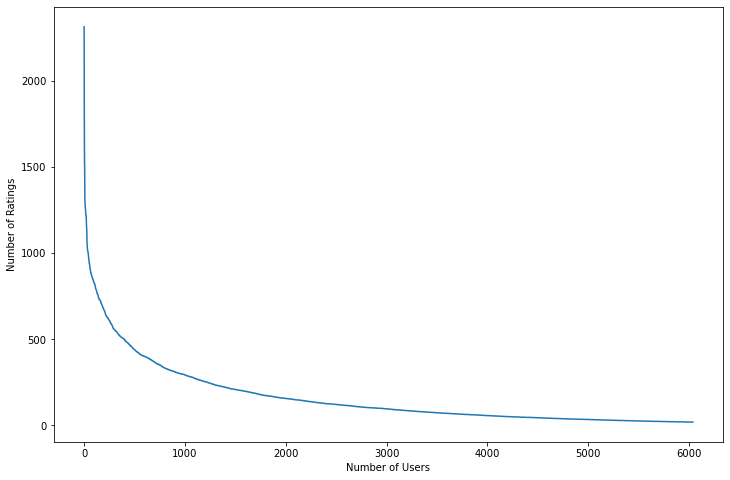

In [84]:
import matplotlib.pyplot as plt
def user_rating_distribution(ratings):
    """
    유저ID로 그룹화한 후 유저당 남긴 평가 수를 센 후,
    내림차순으로 정렬
    """
    sort_ratings = ratings.groupby(['UserID'])['MovieID'].nunique().sort_values(ascending=False).reset_index()
    plt.figure(figsize=(12, 8))
    plt.plot(sort_ratings.iloc[:,1])
    plt.xlabel('Number of Users')
    plt.ylabel('Number of Ratings')
    
user_rating_distribution(ratings)

리뷰를 많이 쓴 사람은 적고, 리뷰를 적게 쓴 사람은 많은, 어찌보면 우리의 통념과 일치합니다.

그렇다면 이번엔 item의 관점에서 유저와 동일하게 많은 rating을 받은 영화는 적을까요?

마찬가지로 이를 확인하는 함수를 작성해 시각화하여 알아보겠습니다.

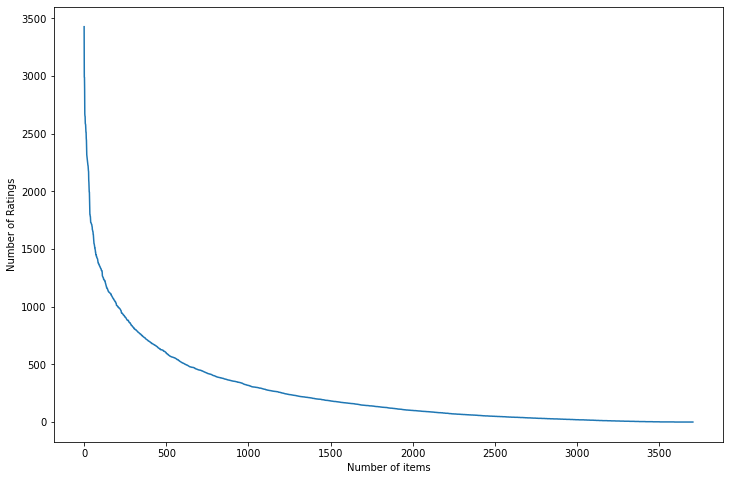

In [85]:
def user_rating_distribution(ratings):
    """
    1. MovieID로 그룹화한 다음 UserID를 카운트합니다.
    2. 내림차순으로 정렬 후 값만 가져옴
    note: import matplotlib.pyplot as plt를 하지 않았다면 먼저 라이브러리를 임포트해야함.
    """
    sort_ratings = ratings.groupby(['MovieID'])['UserID'].nunique().sort_values(ascending=False).values
    plt.figure(figsize=(12, 8))
    plt.plot(sort_ratings)
    plt.xlabel('Number of items')
    plt.ylabel('Number of Ratings')
    
user_rating_distribution(ratings)

아이템도 유저와 똑같은 양상을 띄고 있습니다. (다만 x, y축의 범위만 다릅니다.)

대부분의 아이템은 평가가 적고, 많은 수의 평가를 받은 아이템은 소수입니다.


### 시간에 따른 훈련-테스트 셋 분리
이번에는 데이터를 시간 순으로 정렬하고 8:2의 비율로 훈련 데이터셋과 테스트 데이터 셋을 분리하겠습니다.

데이터 셋을 분리할 때 한 가지 주의할 점이 있습니다.

- 추천 시스템은 현실 문제를 다루기 때문에, 미래의 정보를 활용하여 과거를 예측하는 것은 모순입니다.

    - 따라서 훈련 셋과 테스트 데이터 셋을 분리할 때 시간에 따라 나누는 것이 일반적입니다.

In [86]:
def temporal_sampling(ratings):
    """
    sklearn의 train_test_split을 사용하지 않고 데이터를 분리하겠습니다.
    보통 러신머닝 문제에서는 랜덤샘플링을 하기 때문입니다. (물론 shuffle 옵션을 끌 수도 있습니다)
    """
    # 데이터의 80%에 해당하는 인덱스
    ratio = int(len(ratings)*0.8) 
    # 훈련 셋 분리
    train = ratings.sort_values('timestamp').iloc[:ratio,:]
    # 테스트 셋 분리
    test = ratings.sort_values('timestamp').iloc[ratio:,:]
    return train, test

train, test = temporal_sampling(ratings)

In [87]:
train.head(10)

,UserID,MovieID,Rating,timestamp
1000138,6040,858,4,956703932
1000153,6040,2384,4,956703954
999873,6040,593,5,956703954
1000007,6040,1961,4,956703977
1000192,6040,2019,5,956703977
999877,6040,1419,3,956704056
999920,6040,213,5,956704056
999967,6040,3111,5,956704056
999868,6040,573,4,956704056
999980,6040,3505,4,956704056


In [88]:
test.head(10)

,UserID,MovieID,Rating,timestamp
314160,1875,1721,4,975768738
314032,1875,2621,4,975768748
94555,635,3095,5,975768756
94640,635,36,5,975768756
94578,635,608,5,975768756
94584,635,1177,4,975768756
94598,635,2501,4,975768756
314201,1875,11,4,975768767
314247,1875,539,4,975768777
314161,1875,1722,4,975768786


### 훈련-테스트 딕셔너리 생성
훈련 테스트 셋을 1.`유저`가 어떤 2.`영화`의 3.`평점`을 몇 점을 매겼는지 나타내는 딕셔너리를 생성합니다.

이때 1은 딕셔너리의 key가 되고, value가 다시 딕셔너리가 되어 2가 key, 3이 value인 이중 딕셔너리 입니다.

유저는 UserID로 오름차 순 정렬합니다.

In [128]:
from collections import defaultdict
train_dic = {}
test_dic = {}
def generate_dic(train, test):
    train_dic = {}
    test_dic = {}
    for k, v in train[['UserID', 'MovieID']].values:
        train_dic[k].append(v)
    
    
    return train_dic, test_dic
train_dic, test_dic = generate_dic(train, test)
train_dic

KeyError: 6040

In [123]:
train[['UserID', 'MovieID']].values

array([[6040,  858],
       [6040, 2384],
       [6040,  593],
       ...,
       [1875,  440],
       [1875,  509],
       [1875, 2065]], dtype=int64)

In [115]:
train[['UserID', 'MovieID']]

,UserID,MovieID
1000138,6040,858
1000153,6040,2384
999873,6040,593
1000007,6040,1961
1000192,6040,2019
...,...,...
314102,1875,802
314151,1875,892
314073,1875,440
314225,1875,509


In [113]:
train

,UserID,MovieID,Rating,timestamp
1000138,6040,858,4,956703932
1000153,6040,2384,4,956703954
999873,6040,593,5,956703954
1000007,6040,1961,4,956703977
1000192,6040,2019,5,956703977
...,...,...,...,...
314102,1875,802,4,975768718
314151,1875,892,4,975768719
314073,1875,440,4,975768738
314225,1875,509,4,975768738


In [108]:
for j,k in users.iteritems():
    for l,m in k.iteritems():
        print "%s %s %s" % (j,l, m)



{'UserID': {1000138: 6040,
  1000153: 6040,
  999873: 6040,
  1000007: 6040,
  1000192: 6040,
  999877: 6040,
  999920: 6040,
  999967: 6040,
  999868: 6040,
  999980: 6040,
  1000155: 6040,
  999971: 6040,
  999888: 6040,
  999884: 6040,
  1000186: 6040,
  1000063: 6040,
  999953: 6040,
  999991: 6040,
  1000108: 6040,
  1000083: 6040,
  999938: 6040,
  999946: 6040,
  1000158: 6040,
  1000200: 6040,
  999992: 6040,
  1000101: 6040,
  999999: 6040,
  1000179: 6040,
  1000014: 6040,
  999925: 6040,
  1000115: 6040,
  1000094: 6040,
  999983: 6040,
  1000139: 6040,
  999936: 6040,
  1000163: 6040,
  1000206: 6040,
  1000196: 6040,
  999970: 6040,
  999931: 6040,
  1000117: 6040,
  1000141: 6040,
  999969: 6040,
  1000137: 6040,
  1000129: 6040,
  999924: 6040,
  999926: 6040,
  1000116: 6040,
  1000145: 6040,
  1000205: 6040,
  1000024: 6040,
  1000023: 6040,
  1000168: 6040,
  1000004: 6040,
  1000181: 6040,
  1000202: 6040,
  999869: 6040,
  1000026: 6040,
  1000109: 6040,
  999989: 6

In [95]:
train

,UserID,MovieID,Rating,timestamp
1000138,6040,858,4,956703932
1000153,6040,2384,4,956703954
999873,6040,593,5,956703954
1000007,6040,1961,4,956703977
1000192,6040,2019,5,956703977
...,...,...,...,...
314102,1875,802,4,975768718
314151,1875,892,4,975768719
314073,1875,440,4,975768738
314225,1875,509,4,975768738


In [101]:
train.to_dict()['UserID'].items

<function dict.items>

In [103]:
for i, j, k in train.UserID, train.MovieID, train.Rating:
    train_dic[i].append(j)

ValueError: too many values to unpack (expected 3)

In [93]:
s = [('yellow', 1), ('blue', 2), ('yellow', 3), ('blue', 4), ('red', 1)]
d = defaultdict(list)
for k, v in s:
    d[k].append(v)

sorted(d.items())

[('blue', [2, 4]), ('red', [1]), ('yellow', [1, 3])]

In [90]:
from collections import defaultdict
train_dic = defaultdict(lambda: defaultdict(set))

In [105]:
train

,UserID,MovieID,Rating,timestamp
1000138,6040,858,4,956703932
1000153,6040,2384,4,956703954
999873,6040,593,5,956703954
1000007,6040,1961,4,956703977
1000192,6040,2019,5,956703977
...,...,...,...,...
314102,1875,802,4,975768718
314151,1875,892,4,975768719
314073,1875,440,4,975768738
314225,1875,509,4,975768738
